In [14]:
# Cell 1: Pre-calculated EER threshold from AASIST on ASVspoof2019 LA
CALIBRATED_THRESHOLD = 1.4938   # 0.83% EER
MODEL_INFO = "AASIST (calibrated on ASVspoof2019 LA)"

print(f"Using EER threshold = {CALIBRATED_THRESHOLD:.4f} ({CALIBRATED_THRESHOLD*100:.2f}% EER) for {MODEL_INFO}")
print("Interpretation: scores < threshold ⇒ classified as spoof")

Using EER threshold = 1.4938 (149.38% EER) for AASIST (calibrated on ASVspoof2019 LA)
Interpretation: scores < threshold ⇒ classified as spoof


In [16]:
# Cell 2: Load BRSpeech-DF scores for AASIST
from deepfake_eval.loaders import BRSpeechDFLoader
from deepfake_eval.path_utils import data_path
import pandas as pd # Ensure pandas is imported if not already by loader

# Construct absolute paths under data/…
bonafide_pkl = str(data_path("scores", "aasist", "aasist_brspeech_test_scores.pkl"))
spoof_pkl    = str(data_path("scores", "aasist", "aasist_sintetico_test_scores.pkl"))

# --- Define filters ---
subset_to_load = 'test'
# Bonafide-specific conditions are now generally handled by using the dedicated bonafide metadata file.
# If you had other conditions for bonafide files based on columns *within* brspeech_meta.csv, they'd go here.
bonafide_conditions = None # Or specify if needed, e.g., {'some_col_in_bonafide_meta': 'value'}

# Spoof-specific conditions (e.g., filter by TTS model)
# spoof_conditions = {'tts': 'xtts'} # Example: filter for only 'xtts'
spoof_conditions = None # Load all spoof files

# df_class_to_load = None # Example: 'bonafide' or 'spoof'

print(f"Applying filters to BRSpeechDFLoader:")
print(f"  Subset filter: '{subset_to_load}'")
if bonafide_conditions:
    print(f"  Bonafide conditions: {bonafide_conditions}")
if spoof_conditions:
    print(f"  Spoof conditions: {spoof_conditions}")
# if df_class_to_load:
#     print(f"  df_class filter: '{df_class_to_load}'")
print("-" * 30)

loader_brs = BRSpeechDFLoader.from_pickles(
    bonafide_pkl=bonafide_pkl,
    spoof_pkl=spoof_pkl,
    model_name="AASIST",
    # bonafide_metadata_file and spoof_metadata_file will use defaults:
    # data/metadata/brspeech_df/brspeech_meta.csv
    # data/metadata/brspeech_df/synthetic_meta.csv
    subset_filter=subset_to_load,
    bonafide_metadata_conditions=bonafide_conditions,
    spoof_metadata_conditions=spoof_conditions
    # df_class_filter=df_class_to_load # Uncomment to use
)

# Inspect
df_brs = loader_brs.to_dataframe() # This df is now filtered by the loader
print(f"\nLoaded {len(df_brs)} total samples after loader-internal filtering:")
if not df_brs.empty:
    print(df_brs['df_class'].value_counts().to_dict())

    # Optional: Display more details about the filtered data
    # The 'brspeech' column is no longer expected in the combined df from the new loader
    # if 'brspeech' in df_brs.columns: 
    #     print("\nDetails for 'brspeech' column in bonafide samples (if any):")
    #     print(df_brs[df_brs['df_class'] == 'bonafide']['brspeech'].value_counts(dropna=False).to_dict())
    if 'subset' in df_brs.columns:
        print("\nSubset distribution in loaded data:")
        print(df_brs['subset'].value_counts(dropna=False).to_dict())
    if 'tts' in df_brs.columns and not df_brs[df_brs['df_class'] == 'spoof'].empty :
        print("\nTTS distribution for spoof samples in loaded data:")
        print(df_brs[df_brs['df_class'] == 'spoof']['tts'].value_counts(dropna=False).to_dict())
else:
    print("DataFrame is empty after filtering.")

# Ensure df_brs is not empty before proceeding to other cells
if df_brs.empty:
    print("\n\nERROR: df_brs is empty after loading and filtering. Subsequent cells might fail.")
    # You might want to raise an error here or handle it, e.g.
    # raise ValueError("No data loaded after applying filters. Stopping execution.")

Applying filters to BRSpeechDFLoader:
  Subset filter: 'test'
------------------------------


Building BRSpeech-DF records: 100%|██████████| 7907/7907 [00:00<00:00, 106773.43it/s]


Loaded 7907 total samples after loader-internal filtering:
{'spoof': 6587, 'bonafide': 1320}

Subset distribution in loaded data:
{'test': 7907}

TTS distribution for spoof samples in loaded data:
{'toucantts': 1320, 'xtts': 1320, 'f5tts': 1316, 'yourtts': 1316, 'fish-speech': 1315}


In [17]:
# Cell 3: Compute classification metrics at the pre-calibrated threshold
from deepfake_eval.metrics import compute_metrics_at

metrics2 = loader_brs.metrics_at(CALIBRATED_THRESHOLD)
metrics2

{'threshold': 1.4938,
 'tpr': 0.727645362076818,
 'fpr': 0.8553030303030303,
 'fnr': 0.27235463792318204,
 'precision': 0.80935494765282,
 'recall': 0.727645362076818,
 'f1': 0.7663282436645615,
 'accuracy': 0.630327557860124}

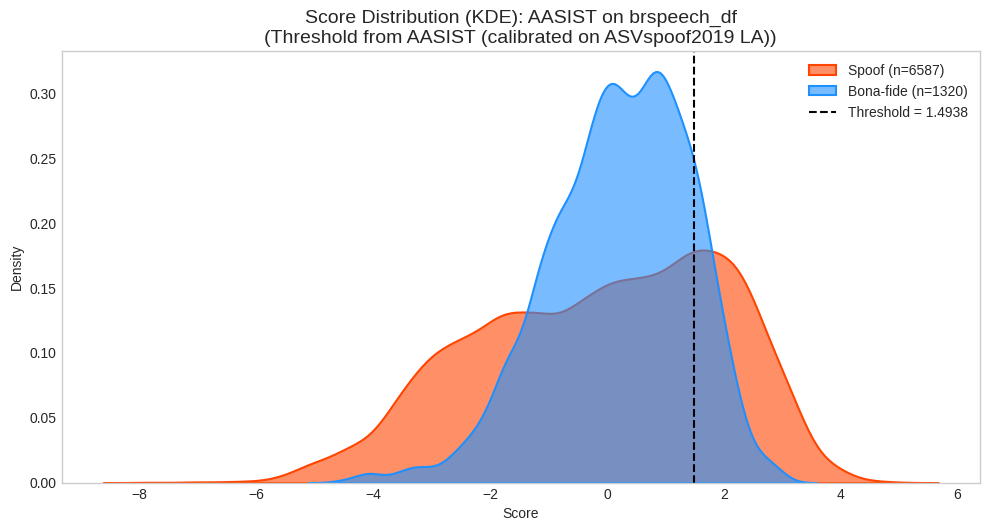

In [18]:
# Cell 4: Plot Score Distributions (Now as Filled KDEs)
import matplotlib.pyplot as plt
from deepfake_eval.plotting import set_style, plot_score_histogram
import pandas as pd

set_style(style='seaborn-v0_8-whitegrid') 

plot_title = f'Score Distribution (KDE): {loader_brs.model_name} on {loader_brs.dataset_name}\n(Threshold from {MODEL_INFO})'

plot_score_histogram(
    df=df_brs,
    threshold=CALIBRATED_THRESHOLD,
    title=plot_title,
    figsize=(10, 5),      # Adjust figure size as desired
    only_kde=True,        # KEY: Plot only KDEs
    kde_alpha=0.6         # KEY: Transparency for the filled KDE areas
    # bins, fill_hist, alpha, show_kde are ignored when only_kde=True
)


--- Overall Performance (Threshold = 1.4938) ---
Classification Report:
               precision    recall  f1-score   support

       Spoof       0.81      0.73      0.77      6587
   Bona fide       0.10      0.14      0.12      1320

    accuracy                           0.63      7907
   macro avg       0.45      0.44      0.44      7907
weighted avg       0.69      0.63      0.66      7907

--------------------------------------------------


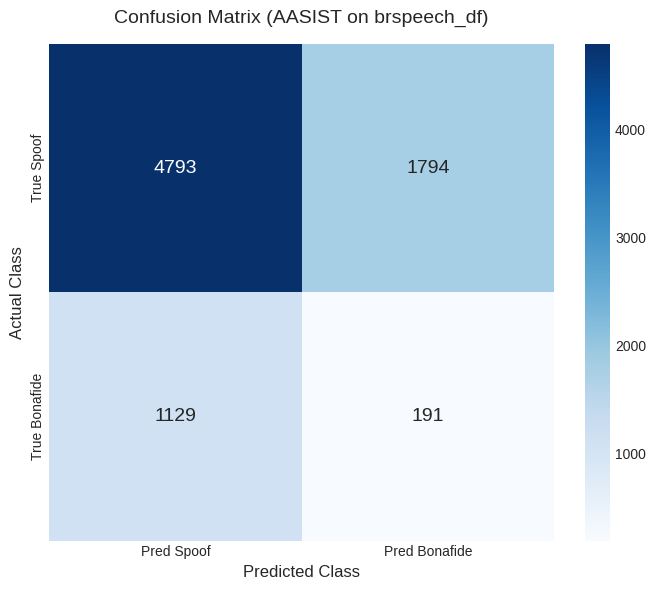

In [19]:
# Cell 5 (Refactored): Overall Confusion Matrix and Metrics Plot
from sklearn.metrics import classification_report # Keep for text report
from deepfake_eval.plotting import plot_confusion_matrix

# Apply threshold to the full DataFrame
df_brs['detected_as_fake'] = df_brs['score'] < CALIBRATED_THRESHOLD

# Map boolean predictions/labels to numeric for sklearn report
y_true_numeric = (df_brs['df_class'] == 'bonafide').astype(int) # 1 if bonafide, 0 if spoof
y_pred_numeric = (df_brs['score'] >= CALIBRATED_THRESHOLD).astype(int) # 1 if predicted bona fide, 0 if predicted spoof

# Print Classification Report (Keep)
print(f"\n--- Overall Performance (Threshold = {CALIBRATED_THRESHOLD:.4f}) ---")
report = classification_report(y_true_numeric, y_pred_numeric, target_names=['Spoof', 'Bona fide'])
print("Classification Report:\n", report)
print("-" * 50)

# --- Plot Confusion Matrix using helper ---
plot_title_cell6 = f'Confusion Matrix ({loader_brs.model_name} on {loader_brs.dataset_name})'

plot_confusion_matrix(
    df=df_brs,
    threshold=CALIBRATED_THRESHOLD, # Provide threshold for classification
    score_col="score",              # Column with scores
    label_col="df_class",           # Column with true labels
    pos_label="spoof",              # Value representing the positive class (fake)
    neg_label="bonafide",           # Value representing the negative class (real)
    title=plot_title_cell6,
    cmap='Blues'                   # Color map for heatmap
    # save="aasist_brs_confusion_matrix.png" # Optional: save figure
)


Performance by group calculated. Now plotting...


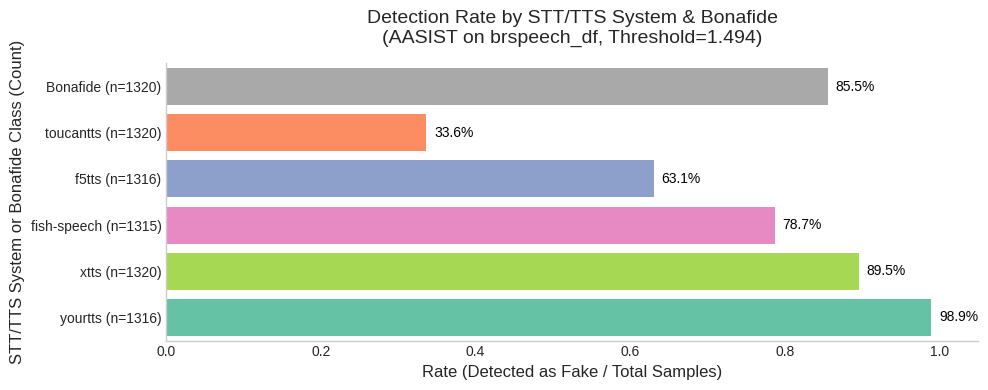

In [20]:
# Cell 6: Analyze performance by STT/TTS system and Bonafide
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deepfake_eval.plotting import plot_rate_by_group # Import the plotting function

# --- Calculations ---
# 1. Create 'detected_as_fake' column based on threshold
df_brs['detected_as_fake'] = df_brs['score'] < CALIBRATED_THRESHOLD

# 2. Group by TTS/STT system and calculate detection rate
df_brs['tts_or_class'] = df_brs.apply(
    lambda row: row['tts'] if row['df_class'] == 'spoof' else 'Bonafide',
    axis=1
)

# Calculate counts and detection rate per group
performance_by_group = df_brs.groupby('tts_or_class').agg(
    detected_fake_count=('detected_as_fake', 'sum'),
    total_samples=('detected_as_fake', 'count')
).reset_index() # Reset index to make 'tts_or_class' a column

performance_by_group['rate'] = performance_by_group['detected_fake_count'] / performance_by_group['total_samples']

# Prepare DataFrame for plotting function (use the calculated 'performance_by_group')
final_performance_for_plot = performance_by_group.copy()

print("Performance by group calculated. Now plotting...")
# print(final_performance_for_plot) # Optional: display the DataFrame to be plotted

# --- Plotting ---
plot_title_cell5 = (f'Detection Rate by STT/TTS System & Bonafide\n'
                    f'({loader_brs.model_name} on {loader_brs.dataset_name}, Threshold={CALIBRATED_THRESHOLD:.3f})')

plot_rate_by_group(
    df=final_performance_for_plot, # Use the calculated DataFrame
    rate_col='rate',               # Column with the rate
    group_col='tts_or_class',      # Column with group names
    count_col='total_samples',     # Column with counts for labels
    sort_by='rate',                # Sort by rate
    ascending=True,                # Sort ascending
    bonafide_label="Bonafide",     # Identify the bonafide group
    bonafide_color='darkgrey',     # Color for bonafide
    palette="Set2",                # Palette for others
    title=plot_title_cell5,
    xlabel='Rate (Detected as Fake / Total Samples)', # Adjusted label
    ylabel='STT/TTS System or Bonafide Class (Count)'
    # save="aasist_brs_rate_by_group.png" # Optional: save figure
)

Selecting Top 5 Spoof TTS models for KDE plot: toucantts, xtts, f5tts, yourtts, fish-speech


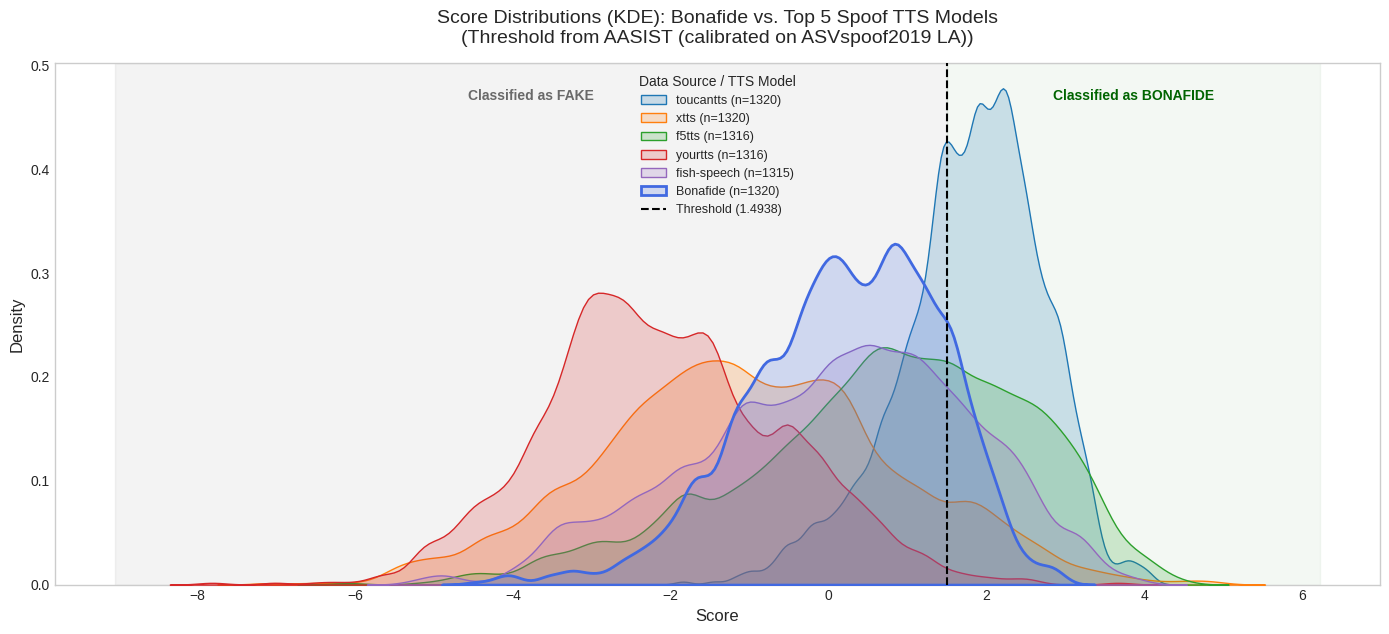

In [21]:
# Cell: Enhanced KDE Plot by TTS Model with Classification Regions & Consistent Colors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from deepfake_eval.plotting import plot_kde_by_tts, set_style # Import the enhanced plotting function

# --- Set Style (Apply once per notebook, ideally near the top) ---
# Make sure to call this in a previous cell or uncomment here.
# set_style(style='seaborn-v0_8-darkgrid', grid_color='white') # Ensure white grid

# --- Ensure necessary variables exist ---
dataframe_to_use = None
if 'df_brs' in locals() and isinstance(df_brs, pd.DataFrame) and not df_brs.empty:
    dataframe_to_use = df_brs
# Add checks for other potential df names if necessary

kde_plot_df = pd.DataFrame() # Initialize empty DataFrame

if dataframe_to_use is None:
    print("Error: DataFrame ('df_brs') not available or empty.")
elif 'CALIBRATED_THRESHOLD' not in locals():
    print("Error: CALIBRATED_THRESHOLD not defined.")
elif 'MODEL_INFO' not in locals():
     print("Error: MODEL_INFO not defined.")
elif 'tts' not in dataframe_to_use.columns:
     print("Error: 'tts' column missing, cannot group for KDE plot.")
else:
    # --- Data Preparation: Select Top N Spoof Models based on 'tts' column ---
    max_spoof_models = 5
    spoof_df = dataframe_to_use[dataframe_to_use['df_class'] == 'spoof'].copy()
    bonafide_df = dataframe_to_use[dataframe_to_use['df_class'] == 'bonafide'].copy()

    identified_spoof_df = spoof_df[spoof_df['tts'].notna() & (spoof_df['tts'] != 'unknown')].copy()

    top_tts_models = []
    if not identified_spoof_df.empty:
        model_counts = identified_spoof_df['tts'].value_counts()
        top_tts_models = model_counts.head(max_spoof_models).index.tolist()
        print(f"Selecting Top {len(top_tts_models)} Spoof TTS models for KDE plot: {', '.join(top_tts_models)}")

        plot_spoof_subset = identified_spoof_df[identified_spoof_df['tts'].isin(top_tts_models)]
        bonafide_df['tts'] = 'Bonafide' # Assign label

        kde_plot_df = pd.concat([bonafide_df, plot_spoof_subset], ignore_index=True)

        category_order = ['Bonafide'] + top_tts_models
        filtered_category_order = [cat for cat in category_order if cat in kde_plot_df['tts'].unique()]
        kde_plot_df['tts'] = pd.Categorical(kde_plot_df['tts'], categories=filtered_category_order, ordered=True)
        kde_plot_df = kde_plot_df.sort_values('tts')

    else:
        print("Warning: No identified TTS models found in spoof data. Plotting Bonafide only.")
        bonafide_df['tts'] = 'Bonafide'
        kde_plot_df = bonafide_df.copy()
        if not kde_plot_df.empty:
             kde_plot_df['tts'] = pd.Categorical(kde_plot_df['tts'], categories=['Bonafide'], ordered=True)


# --- Plotting using ENHANCED helper (only if data is ready) ---
if not kde_plot_df.empty:
    num_spoof_groups_in_plot = len(top_tts_models) if top_tts_models else 0
    plot_title_kde = f"Score Distributions (KDE): Bonafide vs. Top {num_spoof_groups_in_plot} Spoof TTS Models\n(Threshold from {MODEL_INFO})"

    # --- Define CONSISTENT Color Map ---
    # Assign specific colors you want for each potential top model + Bonafide
    # Use colors that work well on the dark grid background
    fixed_color_map = {
        "Bonafide": "royalblue",  # CHANGED from "lightgrey" to "royalblue"
        "toucantts": "#1f77b4",
        "xtts": "#ff7f0e",
        "f5tts": "#2ca02c",
        "yourtts": "#d62728",
        "fish-speech": "#9467bd",
    }
    # Extract the bonafide color and the spoof palette dictionary
    bonafide_plot_color = fixed_color_map.get("Bonafide", "lightgrey")
    spoof_plot_palette = {k: v for k, v in fixed_color_map.items() if k != "Bonafide"}


    # --- Single plotting call with new options ---
    plot_kde_by_tts(
        df=kde_plot_df,
        group_col='tts',
        score_col='score',
        bonafide_label="Bonafide",
        title=plot_title_kde,
        threshold=CALIBRATED_THRESHOLD,
        legend=True,
        show_classification_regions=True,
        legend_title="Data Source / TTS Model",
        # --- Pass the fixed colors ---
        bonafide_color=bonafide_plot_color,
        spoof_palette=spoof_plot_palette, # Pass the dict for spoof models
        show=True
    )
else:
    print("Skipping KDE plot as no data (Bonafide or Spoof) is prepared.")
